<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/MCSO/notebooks/14_DetecccionAnomaliasKerasSeriesTemporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a la detección de anomalías en series temporales con Keras


vamos a verlo en el dominio financiero, quizás el más famoso pero también se usa en muchos más, medicina, ingeniería,...

## Tarea 1: Importación de bibliotecas

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


## Tarea 2: Cargar e inspeccionar los datos del índice S&P 500

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [ ]:
# dataset sencillo con dos columnas, fecha y cierre
# de las 500 empresas tecnológicas
df = pd.read_csv('spx.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [ ]:
df.shape

(8192, 2)

In [ ]:
# como siempre todos los gráficos tienen una amplia cantidad de opciones

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)  # para tener la opción interactiva
fig.show()                          # muy útil para hacer zoom

## Tarea 3: Preprocesamiento de los datos

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [ ]:
# recordad que podemos usar la herramienta train_test_split de sklearn
# from sklearn.model_selection import train_test_split 

# train, test = train_test_split(df, test_size = 0.20)

# print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [ ]:
train.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [ ]:
# sobre estandarización
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [ ]:
train.head()

,date,close
5041,2005-12-22,0.310106
6081,2010-02-11,0.005689
6218,2010-08-27,-0.016591
6775,2012-11-13,0.480910
7298,2014-12-11,1.541594


## Tarea 4: Crear conjuntos de entrenamiento y prueba

In [ ]:
time_steps = 30

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

creamos secuencias para el modelo de series temporales

In [ ]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(train.shape, test.shape)
# entradas, timestamp y una columna
# vemos los diferentes formatos

print(X_train.shape)
print(X_test.shape)

(6553, 2) (1639, 2)
(6523, 30, 1)
(1609, 30, 1)


In [ ]:
X_train.shape[0]

6523

## Tarea 5: Construir un Autoencoder LSTM

In [ ]:
# cogemos los valores que hemos definido en el numpy creado antes, X_train
# [0]
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),             # regularización
    RepeatVector(timesteps),  # replica el número de veces que le digamos
                              # y actúa de puente entre encoder y decoder
    LSTM(128, return_sequences=True),
    Dropout(0.2),             # regularización
    TimeDistributed(Dense(num_features))     # salida normal            
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Tarea 6: Entrenamiento del Autoencoder

In [ ]:
# utilizaremos el earlyStopping que es muy útil
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es], # es es earlystopping, se pueden utilizar otros calbacks
    shuffle=False
)

Epoch 1/10
184/184 [==============================] - 18s 78ms/step - loss: 0.2659 - val_loss: 0.1649
Epoch 2/10
184/184 [==============================] - 13s 73ms/step - loss: 0.1736 - val_loss: 0.0716
Epoch 3/10
184/184 [==============================] - 13s 73ms/step - loss: 0.1237 - val_loss: 0.0745
Epoch 4/10
184/184 [==============================] - 14s 73ms/step - loss: 0.1182 - val_loss: 0.0511
Epoch 5/10
184/184 [==============================] - 13s 73ms/step - loss: 0.0971 - val_loss: 0.0410
Epoch 6/10
184/184 [==============================] - 13s 73ms/step - loss: 0.0953 - val_loss: 0.0452
Epoch 7/10
184/184 [==============================] - 14s 74ms/step - loss: 0.1032 - val_loss: 0.0887
Epoch 8/10
184/184 [==============================] - 14s 74ms/step - loss: 0.1084 - val_loss: 0.0555


## Tarea 7: Representar las métricas y evaluar el modelo

Teendremos un validation loss menor que el training, igual ha habido poco ajuste
se puede "jugar" con los parámetros

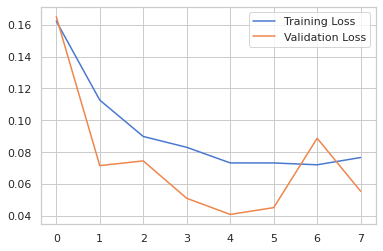

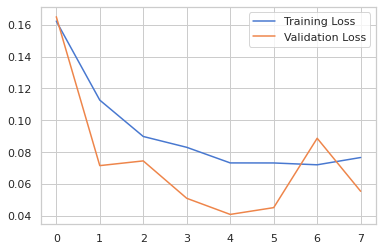

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)

# vemos la diferencia entre lo que se ha predecido y el valor real

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [ ]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 21ms/step - loss: 0.3962


0.39616239070892334

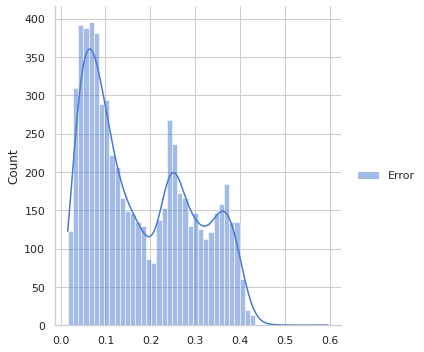

In [ ]:
sns.displot(train_mae_loss, bins=50, kde=True);
# y vemos la discribución del error por medio de loss function

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

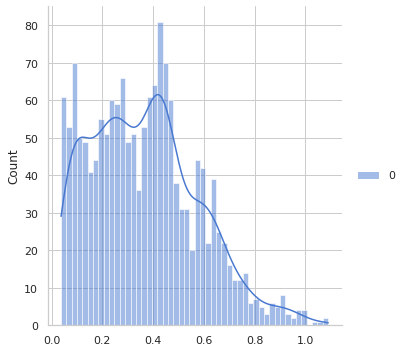

In [ ]:
sns.displot(test_mae_loss, bins=50, kde=True);

## Tarea 8: Detectar anomalías en los datos del índice S&P 500

In [ ]:
# declaramos el umbral para las anomalías, que siempre podremos modificar
THRESHOLD = 0.65

# y vamos creando un nuevo dataframe que indica los valores según haya o no anomalías

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold # útil, lo ponemos como condición
test_score_df['close'] = test[time_steps:].close

In [ ]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.056537,0.65,False
6584,2012-02-09,1.221625,0.056824,0.65,False
6585,2012-02-10,1.199313,0.056619,0.65,False
6586,2012-02-13,1.221194,0.056277,0.65,False
6587,2012-02-14,1.218150,0.055446,0.65,False


vamos a crear esta figura que separe entre el test loss (errores en el test) con el umbral de separación, también podemos hacer zoom

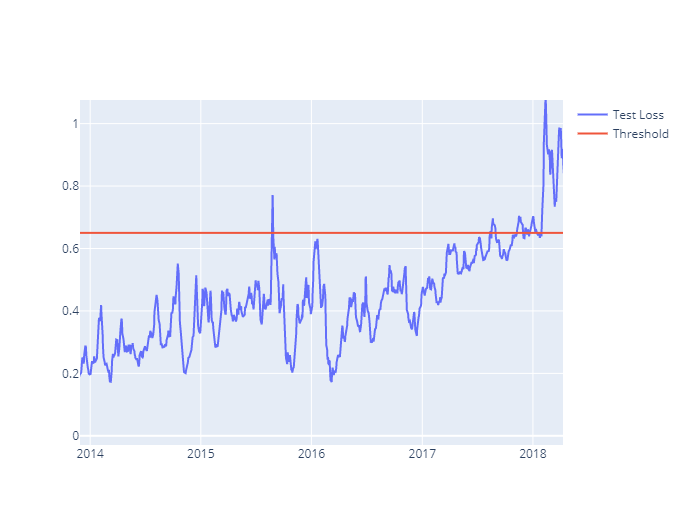

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

creamos un nuevo dataframe para las anomalías, con la condición anomalia a true

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.695000,0.65,True
7475,2015-08-26,2.632149,0.770899,0.65,True
7476,2015-08-27,2.745147,0.725879,0.65,True
7970,2017-08-14,3.891138,0.655695,0.65,True
7974,2017-08-18,3.794580,0.665880,0.65,True


y vemos que el tamaño se ha reducido a 157

In [ ]:
anomalies.shape

(157, 5)

In [ ]:
# necesitamos los valores iniciales antes de hacer la normalización con standarscaler
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()

Igualmente, podremos hacer zoom, que en este caso es muy útil